# **INF4039 Deep Learning Systems**

Individual project

###**Oleksandr Laptiev - IF2200071**

## 1. Dataset description
The dataset used in this work consists of text data in English language, with labels indicating whether the text contains abusive language or not. The dataset is structured with columns for text data and labels (0 or 1), providing a clear basis for training and evaluating machine learning models. Racist or sexist messages are considered hate in this dataset. The dataset contains 20000 of rows and 10% of them are hate. The figure shows part of the dataset.

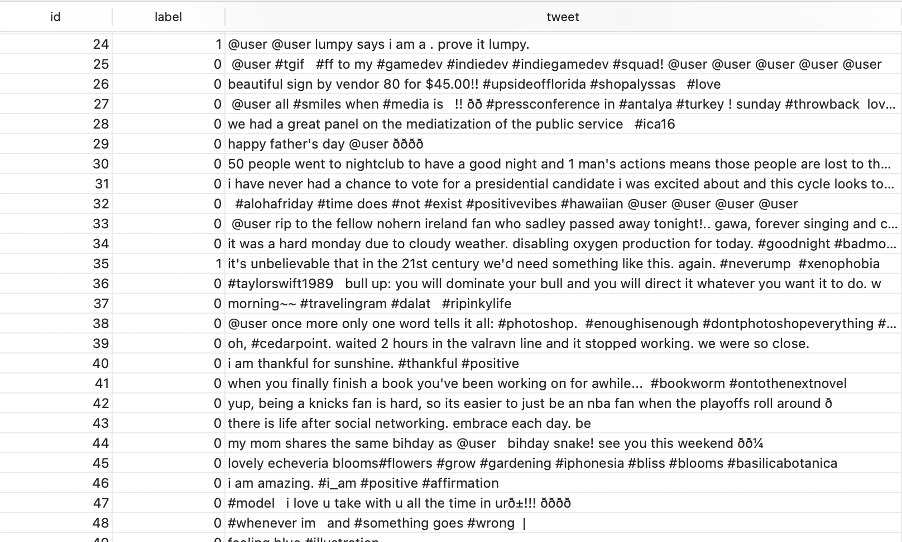

##2. Goals and objectives
The proliferation of digital platforms has provided a fertile ground for the exchange of ideas and information across the globe. However, this has also given rise to the challenge of monitoring and mitigating abusive language, which can be detrimental to the online community. The detection of abusive language is particularly challenging in multilingual contexts, where the nuances of different languages and dialects come into play. This research focuses on the development and comparison of machine learning models for detecting abusive language in texts written in English language.





##3. Data preparation and exploratory data analysis


<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20000 non-null  int64 
 1   label   20000 non-null  int64 
 2   tweet   20000 non-null  object
dtypes: int64(2), object(1)
memory usage: 625.0+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20000 non-null  int64 
 1   label   20000 non-null  int64 
 2   tweet   20000 non-null  object
dtypes: int64(2), object(1)
memory usage: 625.0+ KB
Data Information:
None

Null Values:
id       0
label    0
tweet    0
dtype: int64

Empty Tweets:
0

Duplicate Rows:
0


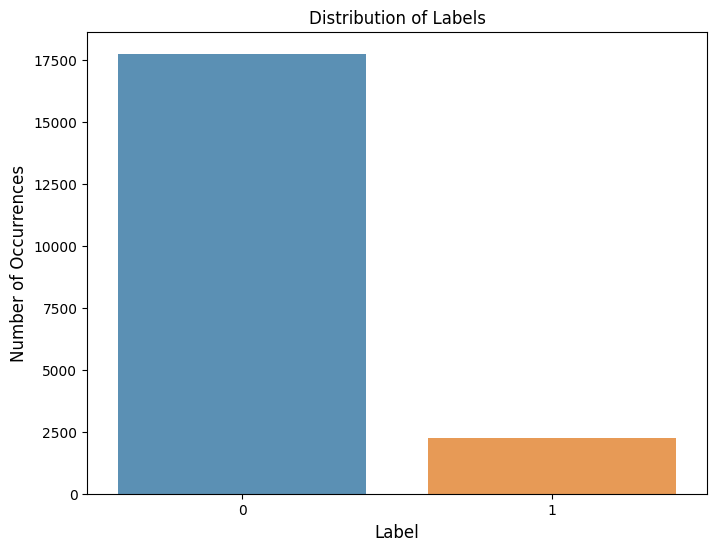

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import re

# Load the dataset
data = pd.read_csv('train.csv')

#Cut off tweets with more than 100 words
def word_count(tweet):
    return len(tweet.split())

filtered_data = data[data['tweet'].apply(word_count) <= 100]

# Perform basic data checks
data_info = filtered_data.info()
null_values = filtered_data.isnull().sum()

# Since we are dealing with text data, we can check for empty strings or only whitespace strings
empty_tweets = filtered_data[filtered_data['tweet'].str.strip() == '']

# Perform basic data checks
data_info = filtered_data.info()
null_values = filtered_data.isnull().sum()
duplicate_rows = filtered_data.duplicated().sum()

# Display basic information
print("Data Information:")
print(data_info)
print("\nNull Values:")
print(null_values)
print("\nEmpty Tweets:")
print(len(empty_tweets))
print("\nDuplicate Rows:")
print(duplicate_rows)

# Remove duplicate rows if any
filtered_data = filtered_data.drop_duplicates()

# Data cleaning function to remove mentions, URLs, and special characters
def clean_tweet(tweet):
    tweet = re.sub(r'@\S+', '', tweet)  # Remove mentions
    tweet = re.sub(r'http\S+', '', tweet)  # Remove URLs
    tweet = re.sub(r'[^A-Za-z0-9\s]+', '', tweet)  # Remove special characters
    return tweet.strip()

# Apply data cleaning function to the 'tweet' column
filtered_data['tweet'] = filtered_data['tweet'].apply(clean_tweet)

# Data preprocessing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(filtered_data['tweet'])
sequences = tokenizer.texts_to_sequences(filtered_data['tweet'])
padded_sequences = pad_sequences(sequences, maxlen=100)

# Split data
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, filtered_data['label'], test_size=0.2, random_state=7)

# Exploratory Data Analysis: Distribution of labels
label_counts = filtered_data['label'].value_counts()

# Plotting label distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8)
plt.title('Distribution of Labels')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Label', fontsize=12)
plt.show()



##4. Machine Learning

For this part of work I chose the k-nn method

In [89]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Initialize the k-NN Classifier
k = 3  # Number of neighbors
knn = KNeighborsClassifier(n_neighbors=k)

# Fit the model on the training data
knn.fit(X_train, y_train)

# Predict on the testing data
y_pred = knn.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")

Accuracy: 0.8855
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94      3550
           1       0.48      0.21      0.29       450

    accuracy                           0.89      4000
   macro avg       0.69      0.59      0.62      4000
weighted avg       0.86      0.89      0.87      4000




As we can see from the model testing results, k-NN gives average results for hate speech detection task.

##5-7. Training and optimization of neural networks
For my work, I chose the following models from the list to compare CNN and LSTM.

In [90]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Bidirectional, Dense, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import RMSprop
import time

# Model building
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100
def build_model(model_type):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=100))
    if model_type == 'LSTM':
        model.add(LSTM(units=128, dropout=0.5, recurrent_dropout=0.5))
    elif model_type == 'CNN':
        model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
        model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Model training
LSTM_model = build_model('LSTM')
LSTM_start_time = time.time()
LSTM_history = LSTM_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
LSTM_training_time = time.time() - LSTM_start_time

CNN_model = build_model('CNN')
CNN_start_time = time.time()
CNN_history = CNN_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))
CNN_training_time = time.time() - CNN_start_time

Epoch 1/10
500/500 [==============================] - 142s 280ms/step - loss: 0.2999 - accuracy: 0.8978 - val_loss: 0.2538 - val_accuracy: 0.9115
Epoch 2/10
500/500 [==============================] - 135s 270ms/step - loss: 0.1972 - accuracy: 0.9284 - val_loss: 0.2059 - val_accuracy: 0.9290
Epoch 3/10
500/500 [==============================] - 144s 289ms/step - loss: 0.1595 - accuracy: 0.9445 - val_loss: 0.1906 - val_accuracy: 0.9308
Epoch 4/10
500/500 [==============================] - 133s 267ms/step - loss: 0.1353 - accuracy: 0.9542 - val_loss: 0.1914 - val_accuracy: 0.9380
Epoch 5/10
500/500 [==============================] - 139s 278ms/step - loss: 0.1197 - accuracy: 0.9619 - val_loss: 0.1813 - val_accuracy: 0.9395
Epoch 6/10
500/500 [==============================] - 131s 262ms/step - loss: 0.1032 - accuracy: 0.9678 - val_loss: 0.1760 - val_accuracy: 0.9423
Epoch 7/10
500/500 [==============================] - 131s 263ms/step - loss: 0.0890 - accuracy: 0.9726 - val_loss: 0.1916 -

125/125 [==============================] - 1s 10ms/step


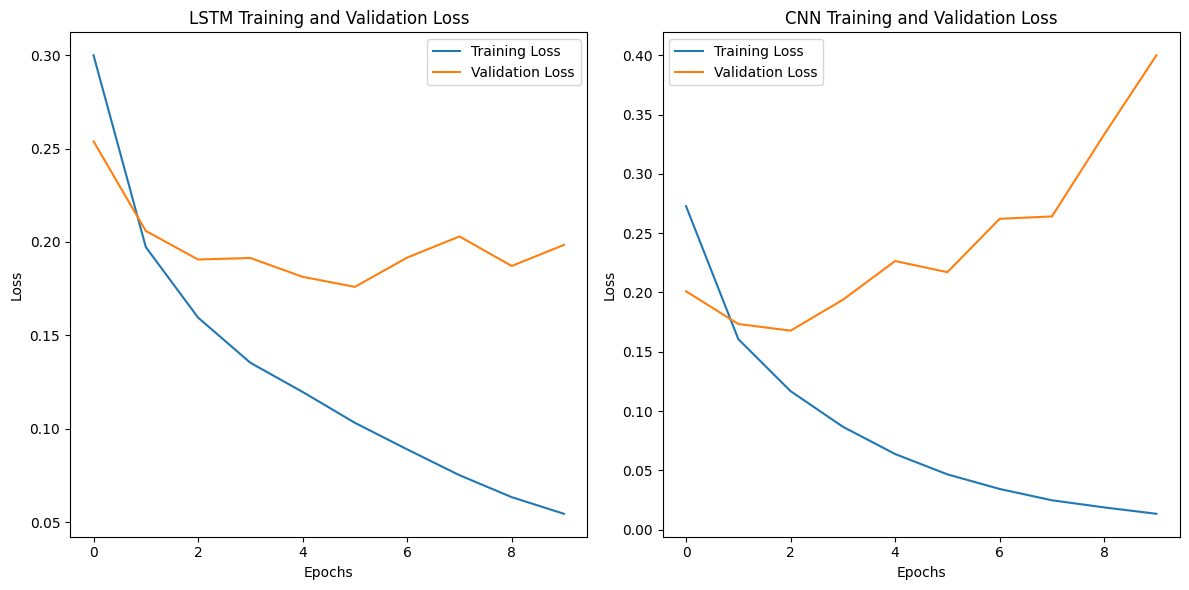

  Model  Training Time (s)  Accuracy  Precision    Recall  F1-score
0  LSTM        1353.943753   0.93775   0.719912  0.731111  0.725469
1  CNN)         202.748589   0.87550   0.468254  0.786667  0.587065


In [91]:
import matplotlib.pyplot as plt
import numpy as np

results = []
LSTM_y_pred = LSTM_model.predict(X_test)
LSTM_y_pred = np.round(LSTM_y_pred).astype(int)
LSTM_accuracy = accuracy_score(y_test, LSTM_y_pred)
LSTM_precision = precision_score(y_test, LSTM_y_pred)
LSTM_recall = recall_score(y_test, LSTM_y_pred)
LSTM_f1 = f1_score(y_test, LSTM_y_pred)
results.append(['LSTM', LSTM_training_time, LSTM_accuracy, LSTM_precision, LSTM_recall, LSTM_f1])

CNN_y_pred = CNN_model.predict(X_test)
CNN_y_pred = np.round(CNN_y_pred).astype(int)
CNN_accuracy = accuracy_score(y_test, CNN_y_pred)
CNN_precision = precision_score(y_test, CNN_y_pred)
CNN_recall = recall_score(y_test, CNN_y_pred)
CNN_f1 = f1_score(y_test, CNN_y_pred)
results.append(['CNN)', CNN_training_time, CNN_accuracy, CNN_precision, CNN_recall, CNN_f1])

# Plotting the training and validation accuracy
plt.figure(figsize=(12, 6))

# LSTM Plots
plt.subplot(1, 2, 1)
plt.plot(LSTM_history.history['loss'], label='Training Loss')
plt.plot(LSTM_history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# CNN Plots
plt.subplot(1, 2, 2)
plt.plot(CNN_history.history['loss'], label='Training Loss')
plt.plot(CNN_history.history['val_loss'], label='Validation Loss')
plt.title('CNN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Display results in a table
results_df = pd.DataFrame(results, columns=['Model', 'Training Time (s)', 'Accuracy', 'Precision', 'Recall', 'F1-score'])
print(results_df)

As can be seen from the graph for the LSTM, 10 epochs are enough to not be overfitted or underfitted. But training takes too long due to their complex structure. For the CNN, we have another situation, model has already been overfitted and needs much fewer epochs for training. Also, even with 10 epochs, it takes the least amount of time to train. Based on the model training results, it was decided to retrain the CNN model with 3 epochs to obtain the most suitable model for hate detection.

Epoch 1/3
500/500 [==============================] - 16s 31ms/step - loss: 0.2749 - accuracy: 0.9022 - val_loss: 0.2021 - val_accuracy: 0.9255
Epoch 2/3
500/500 [==============================] - 16s 31ms/step - loss: 0.1601 - accuracy: 0.9422 - val_loss: 0.1716 - val_accuracy: 0.9420
Epoch 3/3
500/500 [==============================] - 15s 30ms/step - loss: 0.1169 - accuracy: 0.9603 - val_loss: 0.1681 - val_accuracy: 0.9438
CNN Training Accuracy: 0.9975625276565552
CNN Test Accuracy: 0.9024999737739563


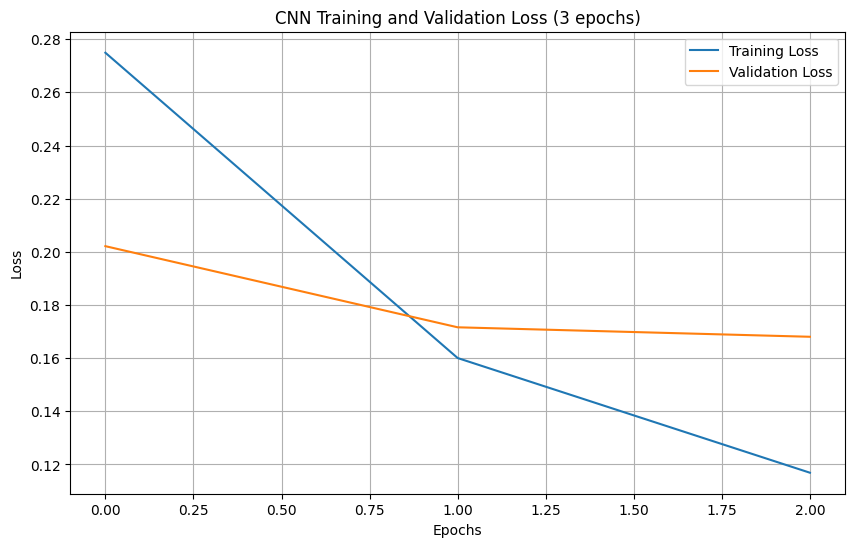

In [98]:
CNN_model = build_model('CNN')
CNN_start_time = time.time()
CNN_history = CNN_model.fit(X_train, y_train, epochs=3, validation_data=(X_test, y_test))
CNN_training_time = time.time() - CNN_start_time

print(f"CNN Training Accuracy: {CNN_train_accuracy}")
print(f"CNN Test Accuracy: {CNN_test_accuracy}")

plt.figure(figsize=(10, 6))
plt.plot(CNN_history.history['loss'], label='Training Loss')
plt.plot(CNN_history.history['val_loss'], label='Validation Loss')
plt.title('CNN Training and Validation Loss (3 epochs)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

##8. Comparison of ML Methods with the best parameters

In [99]:
results = []
LSTM_y_pred = LSTM_model.predict(X_test)
LSTM_y_pred = np.round(LSTM_y_pred).astype(int)
LSTM_accuracy = accuracy_score(y_test, LSTM_y_pred)
LSTM_precision = precision_score(y_test, LSTM_y_pred)
LSTM_recall = recall_score(y_test, LSTM_y_pred)
LSTM_f1 = f1_score(y_test, LSTM_y_pred)
results.append(['LSTM', LSTM_training_time, LSTM_accuracy, LSTM_precision, LSTM_recall, LSTM_f1])

CNN_y_pred = CNN_model.predict(X_test)
CNN_y_pred = np.round(CNN_y_pred).astype(int)
CNN_accuracy = accuracy_score(y_test, CNN_y_pred)
CNN_precision = precision_score(y_test, CNN_y_pred)
CNN_recall = recall_score(y_test, CNN_y_pred)
CNN_f1 = f1_score(y_test, CNN_y_pred)
results.append(['CNN (3 epochs)', CNN_training_time, CNN_accuracy, CNN_precision, CNN_recall, CNN_f1])

results_df = pd.DataFrame(results, columns=['Model', 'Training Time (s)', 'Accuracy', 'Precision', 'Recall', 'F1-score'])
print(results_df)

125/125 [==============================] - 1s 6ms/step
            Model  Training Time (s)  Accuracy  Precision    Recall  F1-score
0            LSTM        1353.943753   0.93775   0.719912  0.731111  0.725469
1  CNN (3 epochs)          47.194837   0.94375   0.844037  0.613333  0.710425


After re-training the CNN model, we can, based on the results, note that if it is more important to identify as many texts with hate as possible (even at the expense of possible false positives), we should look at Recall and choose the LSTM model.

If it is more important to minimize the number of false positives (that is, make sure that texts classified as hate are really hate), we should look at Precision and choose a CNN model.

If we need a balance between these two approaches, we should focus on the F1-score. In this case, the LSTM model is the best choice, but its training time is quite long. And, if training time is critical, CNN can be considered as a fast and efficient option, and f1-score is not very different from LSTM.

##9. Conclusions
As a result, the dataset was prepared, models (CNN, LSTM, k-NN) were also trained and compared. CNN performed best as it has the best f1-score and accuracy and also learns very quickly. Exploring additional datasets or different sets of features could yield further improvements in model performance.